In [1]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.base import BaseEstimator

sys.path.append(r"E:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\libs")

from libs.utils import *

DATASET_PATH = r"E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-not-remv-stopwords.csv"

# 1. Load và xử lý dữ liệu:

In [2]:
data = read_dataset(
    dataset_path= DATASET_PATH,
    file_type="csv",
    header=0
)

13:52:32 root INFO: Đang đọc dữ liệu từ file E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-not-remv-stopwords.csv ...
		at Line 330 [read_dataset() in utils.py, utils]
13:52:37 root INFO: Đọc thành công! 
		at Line 338 [read_dataset() in utils.py, utils]


In [3]:
data.head()

,Unnamed: 0,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Neutral


In [4]:
data = data.drop(columns=data.columns.values[0], axis=1)
data.head()

,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,phục_vụ_việc,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Neutral


In [5]:
labels : list[str] = data["label"].unique().tolist()
labels.sort(reverse=True)
labels

['Positive', 'Neutral', 'Negative']

In [6]:
n_samples_classes = data["label"].value_counts().to_dict()
n_samples_classes

{'Positive': 1032, 'Neutral': 754, 'Negative': 490}

In [7]:
n_samples : int = len(data)
class_weight : dict[str, float] = {k : n_samples / (len(labels) * n_samples_classes.get(k)) for k in n_samples_classes}
class_weight

{'Positive': 0.7351421188630491,
 'Neutral': 1.0061892130857648,
 'Negative': 1.5482993197278911}

In [8]:
training_set, testing_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
training_set[:10]

,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,phục_vụ_việc,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
2084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Positive
1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
1691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
1860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive


In [9]:
X_train : pd.DataFrame = training_set.drop(columns="label", axis=1)
y_train : pd.Series = training_set["label"].copy()
X_testing : pd.DataFrame = testing_set.drop(columns="label", axis=1)
y_testing : pd.Series = testing_set["label"].copy()

In [10]:
y_train_encode = y_train.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_train_encode.head()

2084    0
1963    0
8       0
1691    2
2111    1
Name: label, dtype: int64

In [11]:
y_testing_encode = y_testing.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_testing_encode.head()

2065    0
1321    0
859     1
408     2
629     0
Name: label, dtype: int64

In [12]:
y_encode_label = {label : i for i, label in enumerate(labels)}

class_weight = {y_encode_label.get(k) : class_weight.get(k) for k in class_weight}
class_weight

{0: 0.7351421188630491, 1: 1.0061892130857648, 2: 1.5482993197278911}

# 2. Huấn luyện mô hình SVM:

## 2.1. Huấn luyện mô hình thử với LinearSVC:

Các siêu tham số gồm có:
* **loss**: `hinge` và `squared_hinge`. Lựa chọn hàm mất mát dạng `hinge` hoặc `squared_hinge`

Hàm mất mát `hinge` có dạng: $ J_n(\bold{w}, b) = \max{(0, 1 - y_n z_n)} $, với $ z_n $ là điểm số của $ \bold{x_n} $ ứng với cặp hệ số $ (\bold{w_n}, b) $, $ y_n $ là đầu ra mong muốn

Hàm mất mát `squared_hinge` có dạng: $ J_n(\bold{w}, b) = (\max{(0, 1 - y_n z_n)})^2 $

Tham khảo tại: https://machinelearningcoban.com/2017/04/13/softmarginsmv/, https://en.wikipedia.org/wiki/

* **penalty**: `l1` và `l2`. Lựa chọn dạng chuẩn hóa.

Chuẩn hóa dạng `l1` không kết hợp được khi loss=`hinge`

Chuẩn hóa dạng `l1` chỉ kết hợp được với `squared_hinge` khi tham số dual=`False`

* **dual**: siêu tham số quyết định việc tối ưu hóa thực hiện theo bài toán dual hoặc primal.

* **tol**: Dung sai dừng vòng lặp. Mặc định tol=`1e-4`

* **C**: Siêu tham số chuẩn hóa. Độ lớn của C tỉ lệ nghịch với mức độ chuẩn hóa.

* **class_weight**: Siêu tham số biểu thị trọng số của lớp.

* **max_iter**: Siêu tham số chỉ định số vòng lặp tối đa mà mô hình chạy trong quá trình tìm kiếm bộ tham số tối ưu.

[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

16:26:29 root INFO: Saving figure 'LinearSVCDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
16:26:29 root INFO: Saved figure 'LinearSVCDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


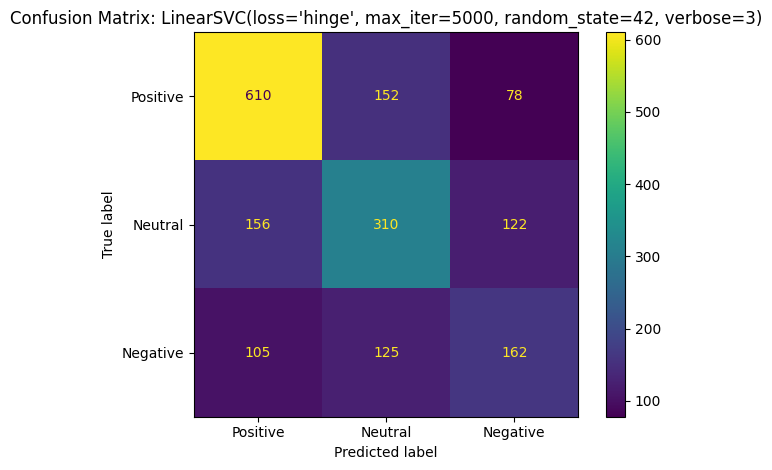

16:26:30 root INFO: 
Average: None
Precision:	[0.70034443 0.52810903 0.44751381]
Recall:		[0.72619048 0.52721088 0.41326531]
--> F1-score:	[0.71303331 0.52765957 0.42970822]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70034443, 0.52810903, 0.44751381]),
 array([0.72619048, 0.52721088, 0.41326531]),
 array([0.71303331, 0.52765957, 0.42970822]))

In [12]:
svc_clf = LinearSVC(loss="hinge", multi_class="ovr", fit_intercept=True, verbose=3, random_state=42, max_iter=5000)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCDefault1")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

16:27:45 root INFO: Saving figure 'LinearSVCDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
16:27:45 root INFO: Saved figure 'LinearSVCDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


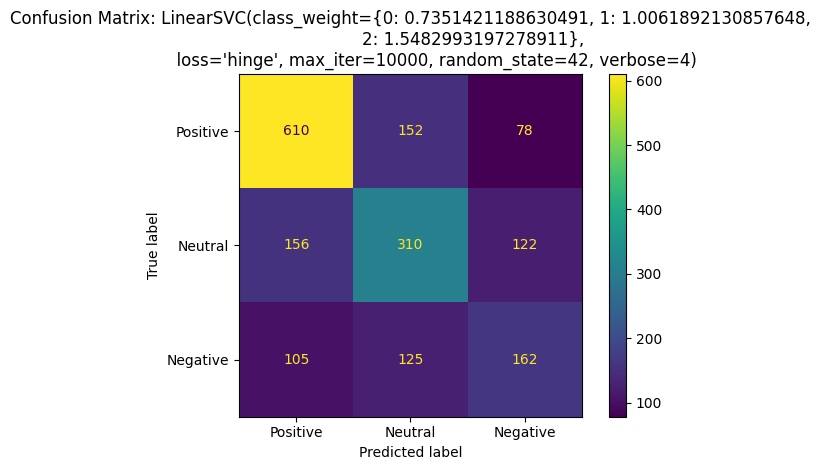

16:27:46 root INFO: 
Average: None
Precision:	[0.70034443 0.52810903 0.44751381]
Recall:		[0.72619048 0.52721088 0.41326531]
--> F1-score:	[0.71303331 0.52765957 0.42970822]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70034443, 0.52810903, 0.44751381]),
 array([0.72619048, 0.52721088, 0.41326531]),
 array([0.71303331, 0.52765957, 0.42970822]))

In [13]:
svc_clf = LinearSVC(loss="hinge", multi_class="ovr", fit_intercept=True, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCDefault2")

[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
16:33:10 root INFO: Saving figure 'LinearSVCDefault3' ...
		at Line 62 [save_fig() in utils.py, utils]
16:33:10 root INFO: Saved figure 'LinearSVCDefault3'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCDefault3.png
		at Line 66 [save_fig() in utils.py, utils]


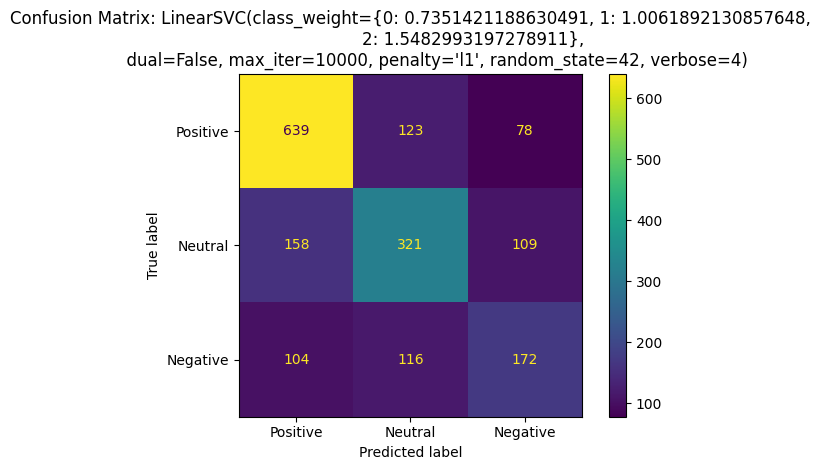

16:33:10 root INFO: 
Average: None
Precision:	[0.70921199 0.57321429 0.47910864]
Recall:		[0.76071429 0.54591837 0.43877551]
--> F1-score:	[0.73406088 0.55923345 0.45805593]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70921199, 0.57321429, 0.47910864]),
 array([0.76071429, 0.54591837, 0.43877551]),
 array([0.73406088, 0.55923345, 0.45805593]))

In [16]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", fit_intercept=True, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000, penalty='l1', dual=False)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCDefault3")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

17:28:22 root INFO: Saving figure 'LinearSVCDefault4' ...
		at Line 62 [save_fig() in utils.py, utils]
17:28:23 root INFO: Saved figure 'LinearSVCDefault4'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCDefault4.png
		at Line 66 [save_fig() in utils.py, utils]


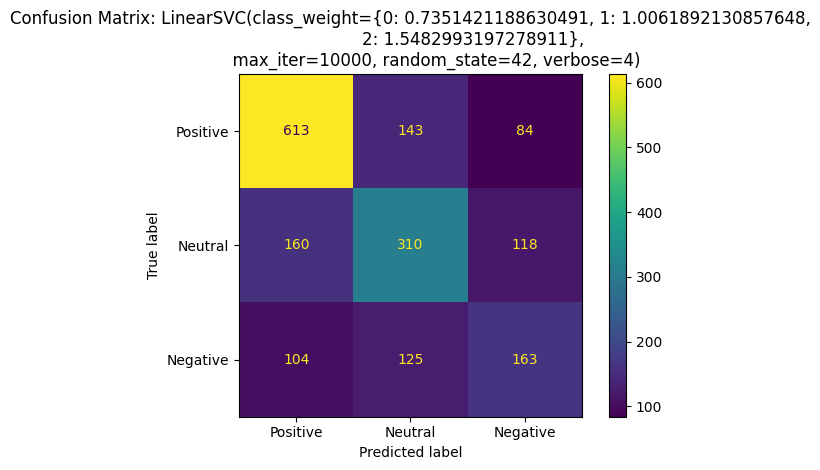

17:28:23 root INFO: 
Average: None
Precision:	[0.69897377 0.53633218 0.44657534]
Recall:		[0.7297619  0.52721088 0.41581633]
--> F1-score:	[0.71403611 0.53173242 0.43064729]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.69897377, 0.53633218, 0.44657534]),
 array([0.7297619 , 0.52721088, 0.41581633]),
 array([0.71403611, 0.53173242, 0.43064729]))

In [17]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", fit_intercept=True, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000, penalty='l2', dual=True)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCDefault4")

[LibLinear][LibLinear][LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

17:30:16 root INFO: Saving figure 'LinearSVCDefault5' ...
		at Line 62 [save_fig() in utils.py, utils]
17:30:16 root INFO: Saved figure 'LinearSVCDefault5'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCDefault5.png
		at Line 66 [save_fig() in utils.py, utils]


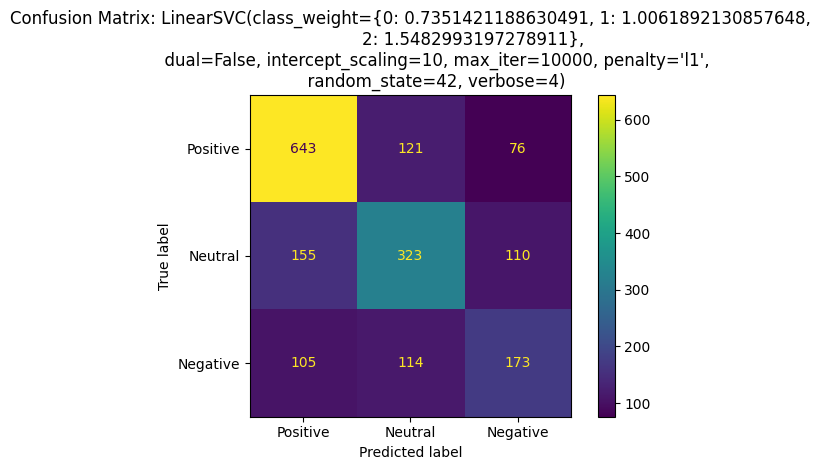

17:30:17 root INFO: 
Average: None
Precision:	[0.71207087 0.57885305 0.48189415]
Recall:		[0.76547619 0.54931973 0.44132653]
--> F1-score:	[0.73780838 0.56369983 0.46071904]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.71207087, 0.57885305, 0.48189415]),
 array([0.76547619, 0.54931973, 0.44132653]),
 array([0.73780838, 0.56369983, 0.46071904]))

In [19]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", fit_intercept=True, intercept_scaling=10, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000, penalty='l1', dual=False)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCDefault5")

Danh sách các tham số của LinearSVC:

In [21]:
svc_clf.get_params()

{'C': 1.0,
 'class_weight': {0: 0.7351421188630491,
  1: 1.0061892130857648,
  2: 1.5482993197278911},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'max_iter': 10000,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 4}

GridSearch tìm bộ tham số tối ưu cho mô hình LinearSVC không scale dữ liệu

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

00:39:19 root INFO: Saving figure 'LinearSVCGridsearchBestParams' ...
		at Line 62 [save_fig() in utils.py, utils]
00:39:20 root INFO: Saved figure 'LinearSVCGridsearchBestParams'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCGridsearchBestParams.png
		at Line 66 [save_fig() in utils.py, utils]


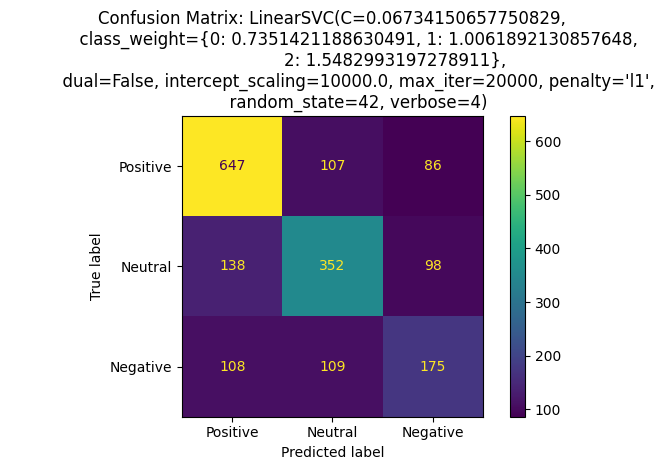

00:39:20 root INFO: 
Average: None
Precision:	[0.72452408 0.61971831 0.48746518]
Recall:		[0.7702381  0.59863946 0.44642857]
--> F1-score:	[0.74668205 0.60899654 0.46604527]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.72452408, 0.61971831, 0.48746518]),
 array([0.7702381 , 0.59863946, 0.44642857]),
 array([0.74668205, 0.60899654, 0.46604527]))

In [23]:
svc_grid_params = [
    {
        'C' : np.logspace(-4, 4, num=100),
        'fit_intercept' : [True, False],
        'intercept_scaling' : np.logspace(1, 4, num=10),
    }
]

svc_grid_search = GridSearchCV(
    estimator=LinearSVC(loss="squared_hinge", multi_class="ovr", class_weight=class_weight, verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False),
    param_grid=svc_grid_params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

svc_grid_search.fit(X_train, y_train_encode)

measure_score(svc_grid_search.best_estimator_, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="LinearSVCGridsearchBestParams")

In [24]:
save_model(estimator=svc_grid_search.best_estimator_, file_name="linear_svc.pkl")

00:41:31 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
00:41:31 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


Đánh giá mô hình tốt nhất của LinearSVC trên tập kiểm thử:

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

13:48:57 root INFO: Saving figure 'BestLinearSVC' ...
		at Line 62 [save_fig() in utils.py, utils]
13:48:58 root INFO: Saved figure 'BestLinearSVC'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\BestLinearSVC.png
		at Line 66 [save_fig() in utils.py, utils]


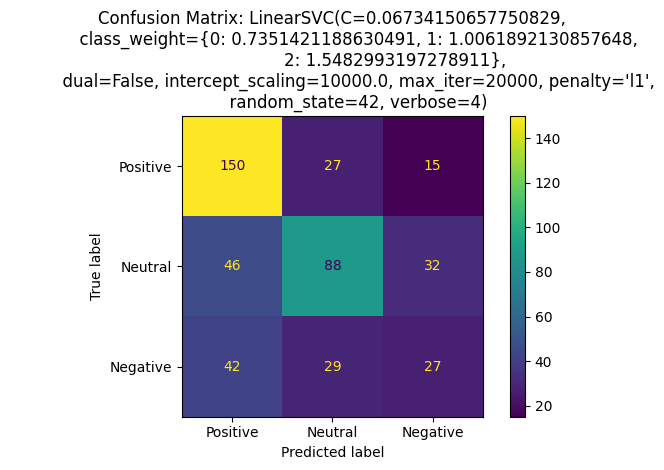

13:48:58 root INFO: 
Average: None
Precision:	[0.6302521  0.61111111 0.36486486]
Recall:		[0.78125    0.53012048 0.2755102 ]
--> F1-score:	[0.69767442 0.56774194 0.31395349]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.6302521 , 0.61111111, 0.36486486]),
 array([0.78125   , 0.53012048, 0.2755102 ]),
 array([0.69767442, 0.56774194, 0.31395349]))

In [25]:
best_linear_svc : LinearSVC  = load_model("linear_svc.pkl")

measure_score(best_linear_svc, X_testing, y_testing_encode, None, labels, cv=10, fig_title="BestLinearSVC")

## 2.2. Huấn luyện mô hình với SVC(Kernal="RBF"):

Các siêu tham số có trong SVC(Kernal="rbf") cần lưu ý:

* **C**: Siêu tham số chuẩn hóa của mô hình. C càng cao lề đường càng nhỏ và ngược lại.

* **gamma**: Siêu tham số độ xa của ảnh hưởng của các đối tượng huấn luyện. Gamma càng cao thì đường phân lớp càng bó sát và quanh co xung quanh không gian đối tượng và ngược lại, gamma càng nhỏ thì đường phân lớp càng rộng và bao một diện tích xa hơn so với không gian đối tượng huấn luyện.

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

00:46:28 root INFO: Saving figure 'SVMRBFDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
00:46:28 root INFO: Saved figure 'SVMRBFDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


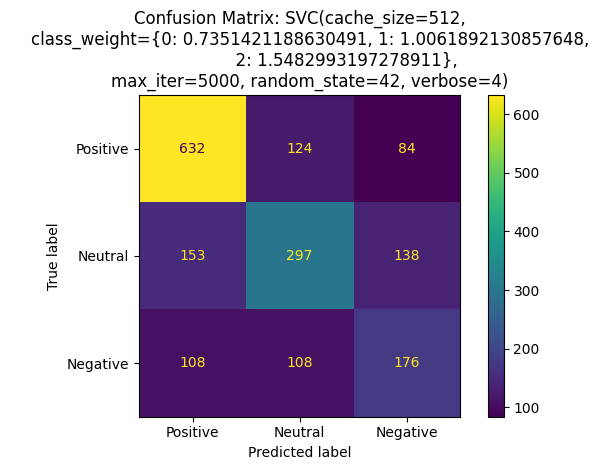

00:46:29 root INFO: 
Average: None
Precision:	[0.70772676 0.56143667 0.44221106]
Recall:		[0.75238095 0.50510204 0.44897959]
--> F1-score:	[0.72937103 0.53178156 0.44556962]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70772676, 0.56143667, 0.44221106]),
 array([0.75238095, 0.50510204, 0.44897959]),
 array([0.72937103, 0.53178156, 0.44556962]))

In [25]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

11:29:29 root INFO: Saving figure 'SVMRBFDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
11:29:29 root INFO: Saved figure 'SVMRBFDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


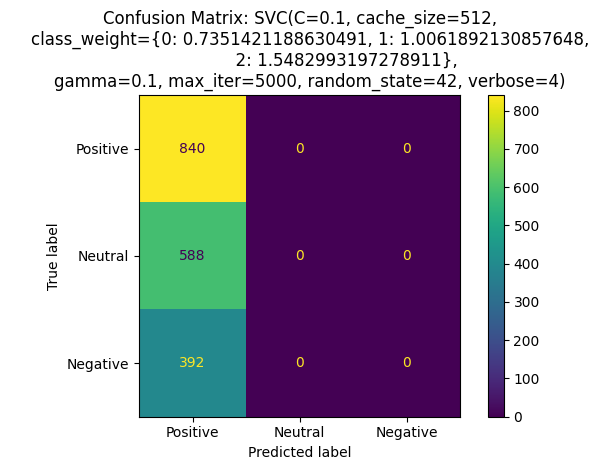

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
11:29:30 root INFO: 
Average: None
Precision:	[0.46153846 0.         0.        ]
Recall:		[1. 0. 0.]
--> F1-score:	[0.63157895 0.         0.        ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.46153846, 0.        , 0.        ]),
 array([1., 0., 0.]),
 array([0.63157895, 0.        , 0.        ]))

In [14]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=0.1, gamma=1e-1)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

11:41:00 root INFO: Saving figure 'SVMRBFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
11:41:00 root INFO: Saved figure 'SVMRBFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


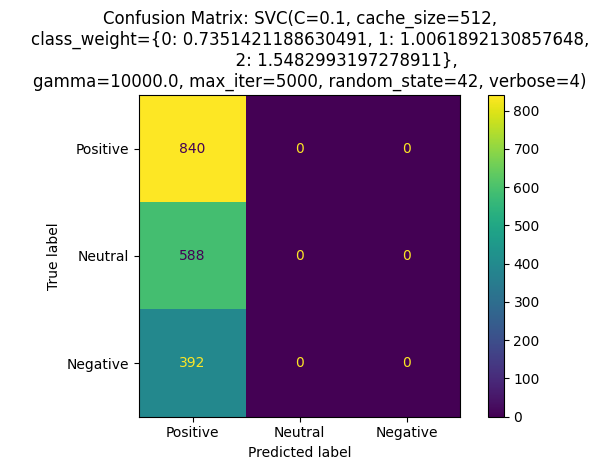

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
11:41:01 root INFO: 
Average: None
Precision:	[0.46153846 0.         0.        ]
Recall:		[1. 0. 0.]
--> F1-score:	[0.63157895 0.         0.        ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.46153846, 0.        , 0.        ]),
 array([1., 0., 0.]),
 array([0.63157895, 0.        , 0.        ]))

In [15]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=0.1, gamma=1e+4)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

11:50:03 root INFO: Saving figure 'SVMRBFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
11:50:03 root INFO: Saved figure 'SVMRBFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


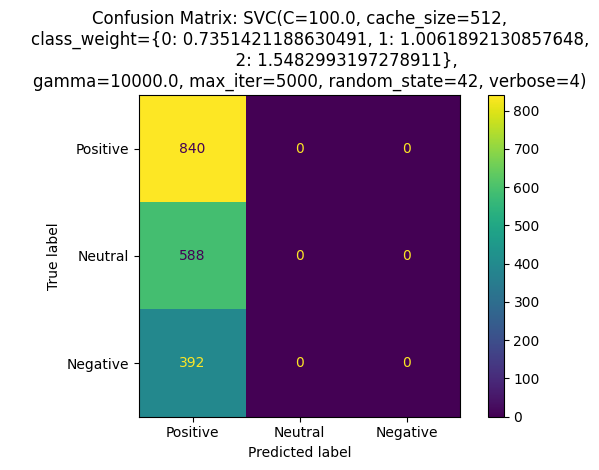

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
11:50:03 root INFO: 
Average: None
Precision:	[0.46153846 0.         0.        ]
Recall:		[1. 0. 0.]
--> F1-score:	[0.63157895 0.         0.        ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.46153846, 0.        , 0.        ]),
 array([1., 0., 0.]),
 array([0.63157895, 0.        , 0.        ]))

In [16]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=1e+2, gamma=1e+4)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

11:57:15 root INFO: Saving figure 'SVMRBFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
11:57:15 root INFO: Saved figure 'SVMRBFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


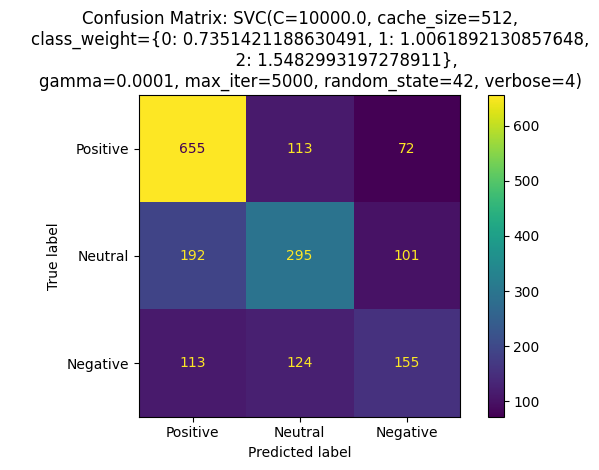

11:57:15 root INFO: 
Average: None
Precision:	[0.68229167 0.55451128 0.47256098]
Recall:		[0.7797619  0.50170068 0.39540816]
--> F1-score:	[0.72777778 0.52678571 0.43055556]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.68229167, 0.55451128, 0.47256098]),
 array([0.7797619 , 0.50170068, 0.39540816]),
 array([0.72777778, 0.52678571, 0.43055556]))

In [17]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=1e+4, gamma=1e-4)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:01:52 root INFO: Saving figure 'SVMRBFDefault3' ...
		at Line 62 [save_fig() in utils.py, utils]
12:01:52 root INFO: Saved figure 'SVMRBFDefault3'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault3.png
		at Line 66 [save_fig() in utils.py, utils]


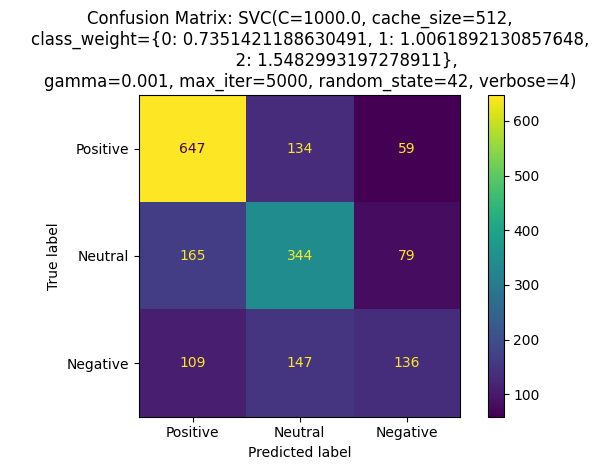

12:01:53 root INFO: 
Average: None
Precision:	[0.70249729 0.5504     0.49635036]
Recall:		[0.7702381  0.58503401 0.34693878]
--> F1-score:	[0.73480977 0.56718879 0.40840841]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70249729, 0.5504    , 0.49635036]),
 array([0.7702381 , 0.58503401, 0.34693878]),
 array([0.73480977, 0.56718879, 0.40840841]))

In [18]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=1e+3, gamma=1e-3)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault3")

GridSearch cho SVM(kernal="rbf")

Sử dụng sigmoid kernel:

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:08:17 root INFO: Saving figure 'SVMSigmoidDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
12:08:17 root INFO: Saved figure 'SVMSigmoidDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


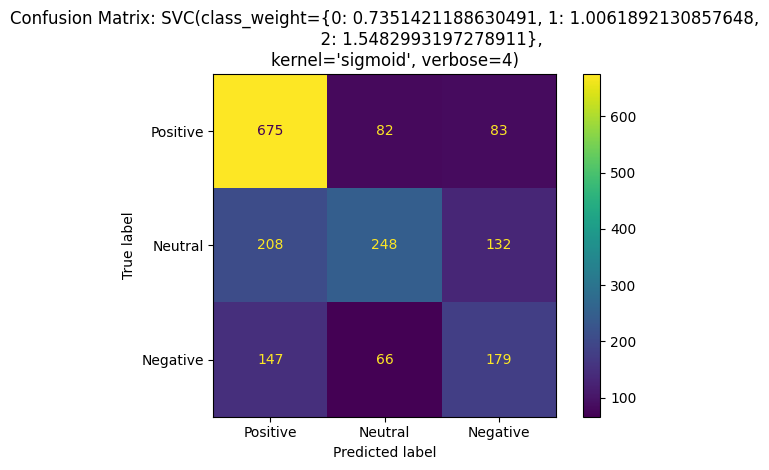

12:08:18 root INFO: 
Average: None
Precision:	[0.65533981 0.62626263 0.45431472]
Recall:		[0.80357143 0.42176871 0.45663265]
--> F1-score:	[0.72192513 0.50406504 0.45547074]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.65533981, 0.62626263, 0.45431472]),
 array([0.80357143, 0.42176871, 0.45663265]),
 array([0.72192513, 0.50406504, 0.45547074]))

In [19]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:23:25 root INFO: Saving figure 'SVMSigmoidDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
12:23:25 root INFO: Saved figure 'SVMSigmoidDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


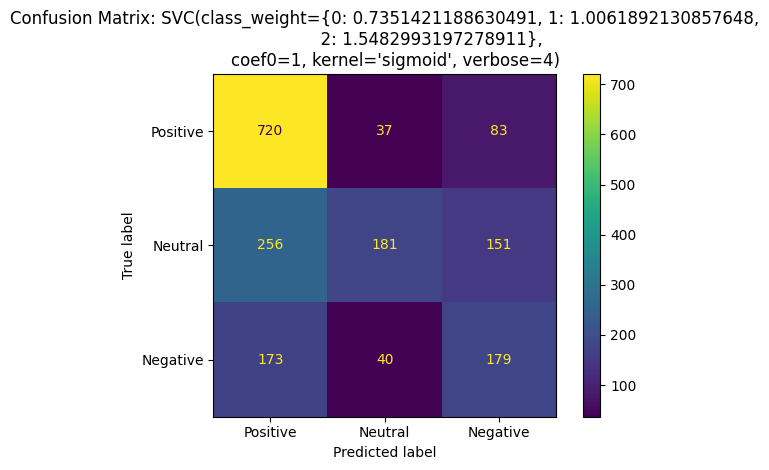

12:23:25 root INFO: 
Average: None
Precision:	[0.62663185 0.70155039 0.43341404]
Recall:		[0.85714286 0.30782313 0.45663265]
--> F1-score:	[0.7239819  0.42789598 0.4447205 ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.62663185, 0.70155039, 0.43341404]),
 array([0.85714286, 0.30782313, 0.45663265]),
 array([0.7239819 , 0.42789598, 0.4447205 ]))

In [21]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1, coef0=1)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:32:38 root INFO: Saving figure 'SVMSigmoidDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
12:32:38 root INFO: Saved figure 'SVMSigmoidDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


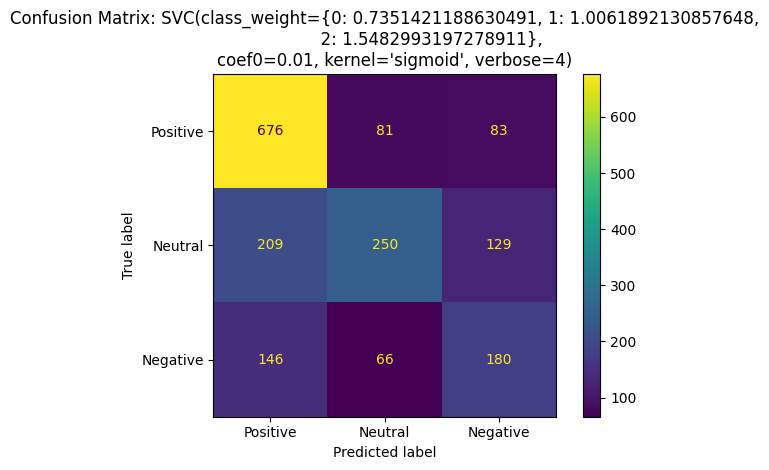

12:32:39 root INFO: 
Average: None
Precision:	[0.6556741  0.62972292 0.45918367]
Recall:		[0.8047619  0.42517007 0.45918367]
--> F1-score:	[0.72260823 0.50761421 0.45918367]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.6556741 , 0.62972292, 0.45918367]),
 array([0.8047619 , 0.42517007, 0.45918367]),
 array([0.72260823, 0.50761421, 0.45918367]))

In [22]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1, coef0=1e-2)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault2")

# 3. Huấn luyện mô hình SVC với đầu vào dữ liệu có thu gọn (Scale):

**Mục tiêu**: Kiểm tra độ chính xác của mô hình khi dữ liệu được thu gọn. SVM rất nhạy cảm với dữ liệu, do đó nếu dữ liệu được thu gọn có thể giúp mở rộng đường phân lớp, phân lớp chính xác hơn.

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

10:47:54 root INFO: Saving figure 'LinearSVCScaled1' ...
		at Line 62 [save_fig() in utils.py, utils]
10:47:55 root INFO: Saved figure 'LinearSVCScaled1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCScaled1.png
		at Line 66 [save_fig() in utils.py, utils]


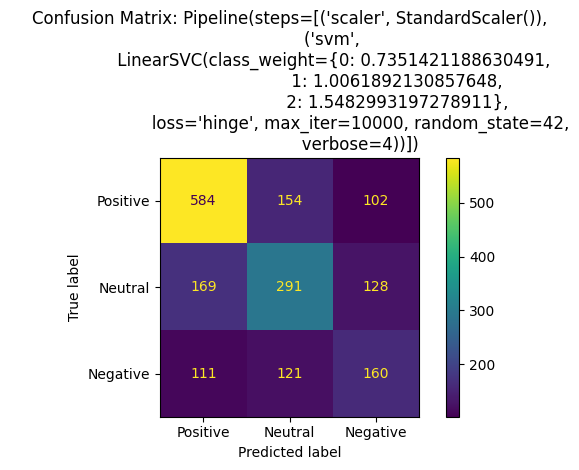

10:47:55 root INFO: 
Average: None
Precision:	[0.67592593 0.51413428 0.41025641]
Recall:		[0.6952381  0.49489796 0.40816327]
--> F1-score:	[0.68544601 0.50433276 0.40920716]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.67592593, 0.51413428, 0.41025641]),
 array([0.6952381 , 0.49489796, 0.40816327]),
 array([0.68544601, 0.50433276, 0.40920716]))

In [13]:
svc_clf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(loss="hinge", multi_class="ovr", fit_intercept=True, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000))
    ]
)

svc_clf_pipeline.fit(X_train, y_train_encode)

measure_score(svc_clf_pipeline, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCScaled1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

14:01:17 root INFO: Saving figure 'SVCRBFScaled' ...
		at Line 62 [save_fig() in utils.py, utils]
14:01:17 root INFO: Saved figure 'SVCRBFScaled'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVCRBFScaled.png
		at Line 66 [save_fig() in utils.py, utils]


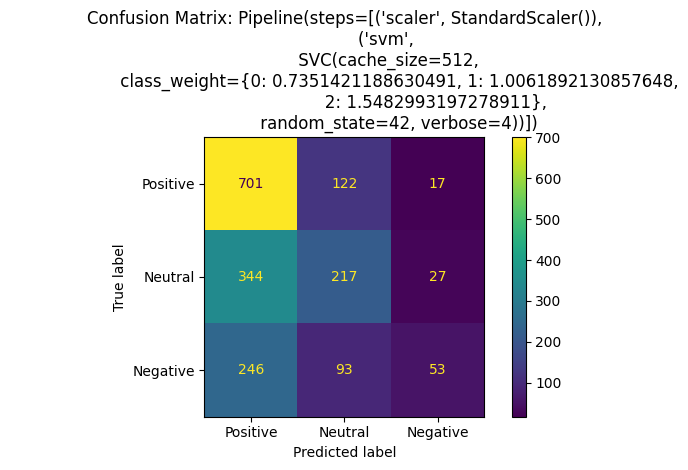

14:01:17 root INFO: 
Average: None
Precision:	[0.54298993 0.50231481 0.54639175]
Recall:		[0.83452381 0.36904762 0.13520408]
--> F1-score:	[0.65790709 0.4254902  0.21676892]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.54298993, 0.50231481, 0.54639175]),
 array([0.83452381, 0.36904762, 0.13520408]),
 array([0.65790709, 0.4254902 , 0.21676892]))

In [13]:
svc_clf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=-1, decision_function_shape="ovr", random_state=42,cache_size=512))
    ]
)

svc_clf_pipeline.fit(X_train, y_train_encode)

measure_score(svc_clf_pipeline, X_train, y_train_encode, None, labels, cv=10, fig_title="SVCRBFScaled")